<a id='step0'></a>
## Import Datasets


* The dataset for dogs is available  at [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).Then we  unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

*  The dataset for humans is available at [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Then we unzip the folder and place it in the home directory, at location `/lfw`.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))


There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

 We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


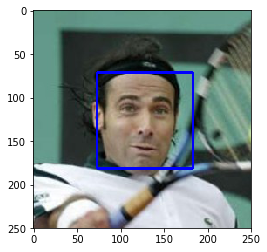

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()


## Human Face Detector
 The function,  named `face_detector`, takes a string-valued file path to an image as input and  returns True if a human face is detected in an image otherwise returns False. 

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

---
<a id='step2'></a>
## Detect Dogs

In this section, we use a pre-trained model to detect dogs in images.  

### Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [4]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("cuda available? {0}".format(use_cuda))
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 88546738.99it/s] 


cuda available? True


### Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive) beacuse the  categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268 (inclusive) of the Imagenet Dataset. 


In [5]:
 from PIL import Image
import torchvision.transforms as transforms
def load_image(img_path):
    image=Image.open(img_path).convert('RGB')
    in_transform=transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406),
                                    (0.229, 0.224, 0.225))])
   ## discard the transparent, alpha channel (that's the :3) and add the batch dimension
#unsqueeze(0) adds a dimension to make it a 4d tensor
    image=in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [6]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
  We  used the  pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image=load_image(img_path)
    if use_cuda:
        image=image.cuda()
    
    VGG16.eval()
    output=VGG16(image)
    _,pred_tensor=torch.max(output,1)
    pred=np.squeeze(pred_tensor.numpy()) if not use_cuda else np.squeeze(pred_tensor.cpu().numpy())
    
    VGG16.train()
    return pred    

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predict=VGG16_predict(img_path)
    return True if 151 <= predict <= 268 else False

In [8]:
print(dog_detector(dog_files[300]))
print(dog_detector(human_files[200]))

True
False


We  use the code cell below to test the performance of your `dog_detector` function. 
 
- What percentage of the images in `human_files`(first 500 images) have a detected dog?  
- What percentage of the images in `dog_files`(first 500 images) have a detected dog?

In [9]:
def dog_detector_test(img_path):
    detection_count=0
    tot_count=len(img_path)
    for img in img_path:
         detection_count+=dog_detector(img)
    return detection_count,tot_count

In [79]:
print(f"{(dog_detector_test(dog_files[:500])[0]/dog_detector_test(dog_files[:500])[1])*100.:3f}% of dogs correctly identified ")
print(f"{(dog_detector_test(human_files[:500])[0]/dog_detector_test(dog_files[:500])[1])*100.:3f}% of dogs confused with humans")


98.600000% of dogs correctly identified 
0.600000% of dogs confused with humans


---
<a id='step4'></a>
##  We will now  classify Dog Breeds (using Transfer Learning)

We  will now use transfer learning to create a CNN that can identify dog breed from images.  

### We Specify Data Loaders for the Dog Dataset

We use the code cell below to write three separate data loaders for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 


In [10]:
import torch
import os
from torchvision import datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

data_dir='/data/dog_images/'
train_dir=os.path.join(data_dir,'train/')
test_dir=os.path.join(data_dir,'test/')
valid_dir=os.path.join(data_dir,'valid/')


In [11]:
import torchvision.transforms as transforms

data_transform={'Train':transforms.Compose([transforms.Resize(224),
                                            transforms.RandomResizedCrop(224),
                                            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),#It is useful since it can make the network more robust to differences in photo quality,such as contrast,exposure, and white balance.
                                           transforms.RandomHorizontalFlip(),# random flip and rotate for better perfomance on unseen data
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]),# convert data to a normalized torch.FloatTensor
               'Test_valid':transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]) # convert data to a normalized torch.FloatTensor
               }

In [12]:
train_data=datasets.ImageFolder(train_dir,transform=data_transform['Train'])
test_data=datasets.ImageFolder(test_dir,transform=data_transform['Test_valid'])
valid_data=datasets.ImageFolder(valid_dir,transform=data_transform['Test_valid'])

In [13]:
batch_size=20

# number of subprocesses to use for data loading
num_workers=0

train_loader=torch.utils.data.DataLoader(train_data,
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data,
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        shuffle=False)
valid_loader=torch.utils.data.DataLoader(valid_data,
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        shuffle=False)

n_classes=len(train_data.classes)# number of dog breeds in our dataset

print('Total number of classes in the dataset',n_classes)

Total number of classes in the dataset 133


###  Model Architecture:


In [14]:
import torchvision.models as models
import torch.nn as nn


model_transfer=models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 82455079.46it/s]


In [15]:
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [16]:
print("Number of inputs going to the final linear layer fc of the  resnet50 model:",model_transfer.fc.in_features)
print("Number of outputs of the final linear layer fc of the resnet50 model:",model_transfer.fc.out_features)

Number of inputs going to the final linear layer fc of the  resnet50 model: 2048
Number of outputs of the final linear layer fc of the resnet50 model: 1000


In [17]:
for param in model_transfer.parameters():
    param.requires_grad=False

In [18]:
import torch.nn as nn
classifier= nn.Linear(2048,n_classes)
model_transfer.fc=classifier

print(model_transfer.fc.in_features)
print(model_transfer.fc.out_features)

use_cuda = torch.cuda.is_available()
print("cuda available? {0}".format(use_cuda))
if use_cuda:
    model_transfer = model_transfer.cuda()

2048
133
cuda available? True


## Changes made to the final Linear layer "fc" of the resnet50 model:

(1):I used the resnet50 architecture for my dog dataset.It is already trained on the imagenet dataset over 1000 classes which makes it a very good feature extractor.


(2)I changed the last  "fc"  Layer of the resnet50 model as it was meant for the Imagenet Dataset having a 2048 inputs and 1000 outputs.SO i changed it with my own Classifier having one linear layers which takes 2048 inputs and gives 133 outputs(number of dog breeds in our dataset).


###  Loss Function and Optimizer

 The next code cell to is used to specify a loss function  and optimizer . We  save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [19]:
import torch.optim as optim
criterion_transfer =nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(),lr=0.001)

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialized variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
                optimizer.zero_grad()
                output=model(data)
                loss=criterion(output,target)
                loss.backward()
                optimizer.step()
                
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))                
          
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
           
            output=model(data)
            loss=criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # printing the  training/validation statistics 
        #Calculating the averge loss
      
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## We Save the model if validation loss has decreased
        if valid_loss<=valid_loss_min:
            
            print('Validation loss decreased({:.6f} --->{:.6f}).Saving Model....'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min=valid_loss
    # returns trained model
    return model



In [20]:
loaders_transfer={'train':train_loader,
                'valid':valid_loader,
                'test':test_loader}


###  Train and Validate the Model

We train and validate the model in the code cell below.  Save the final model parameters  at filepath `'model_transfer.pt'`.

In [35]:
# training the model
model_transfer = train(30, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')




Epoch: 1 	Training Loss: 2.764859 	Validation Loss: 1.005657
Validation loss decreased(inf --->1.005657).Saving Model....
Epoch: 2 	Training Loss: 1.494626 	Validation Loss: 0.812981
Validation loss decreased(1.005657 --->0.812981).Saving Model....
Epoch: 3 	Training Loss: 1.312256 	Validation Loss: 0.636818
Validation loss decreased(0.812981 --->0.636818).Saving Model....
Epoch: 4 	Training Loss: 1.223930 	Validation Loss: 0.589740
Validation loss decreased(0.636818 --->0.589740).Saving Model....
Epoch: 5 	Training Loss: 1.173420 	Validation Loss: 0.552875
Validation loss decreased(0.589740 --->0.552875).Saving Model....
Epoch: 6 	Training Loss: 1.123148 	Validation Loss: 0.581799
Epoch: 7 	Training Loss: 1.134066 	Validation Loss: 0.544079
Validation loss decreased(0.552875 --->0.544079).Saving Model....
Epoch: 8 	Training Loss: 1.084902 	Validation Loss: 0.599959
Epoch: 9 	Training Loss: 1.043642 	Validation Loss: 0.572280
Epoch: 10 	Training Loss: 1.037490 	Validation Loss: 0.54562

In [21]:
# loading the model that got the best validation accuracy 

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: computes the  predicted outputs by passing inputs to the model
        output = model(data)
        # calculates the loss
        loss = criterion(output, target)
        # updating the average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converts output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # comparing predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [23]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.598258


Test Accuracy: 85% (711/836)


In [24]:
from PIL import Image
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def load_input_image(img_path):
    # loading the image 
    image=Image.open(img_path).convert('RGB')
    in_transform=transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    
    image=in_transform(image)[:3,:,:].unsqueeze(0)
    # discard the transparent, alpha channel (that's the :3) and adds a dimension to preprocess the image to 4-d  
    return image

###  Predicting the  Dog Breed with the Model

The  "predict_breed_transfer"  function  takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [25]:
def predict_breed_transfer(img_path,model,device):
    # returning the predicted breed
    image=load_image(img_path)
    if use_cuda:  
        image = image.cuda()
        
        model.eval()
        output=model(image)
        _,pred=torch.max(output,1)# converts output probabilities to predicted class
        pred_img=np.squeeze(pred.numpy()) if not use_cuda else np.squeeze(pred.cpu().numpy())
        
    return class_names[pred]


<a id='step5'></a>

### The run_app fuction accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,

- if a __dog__ is detected in the image, returns the predicted breed.
- if a __human__ is detected in the image, returns the resembling dog breed.
- if __neither__ is detected in the image, provides an output that indicates an error.



In [26]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path)>0:
        
        plt.imshow(Image.open(img_path))
        plt.title('Hello Human!',fontsize=20)
        plt.axis('off')
        plt.show()
        print(f'If you were a dog ... you may look like a {predict_breed_transfer(img_path,model_transfer,use_cuda)}')
        print('\n-----------------------------------\n')
    elif  dog_detector(img_path) is True:
        plt.imshow(Image.open(img_path))
        plt.axis('off')
        plt.show()
        print(f'Dog detected!\n This is a picture of a .... {predict_breed_transfer(img_path,model_transfer,use_cuda)}')
        print('\n-----------------------------------\n')
    else:
        plt.imshow(Image.open(img_path))
        plt.axis('off')
        plt.show()
        print("Error! Can't detect anything.....")
        print('\n-----------------------------------\n')


# Test our  Algorithm on Sample Images!

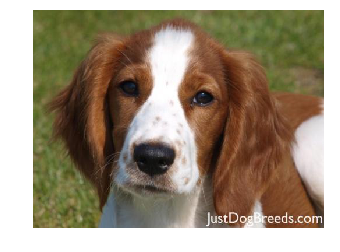

Dog detected!
 This is a picture of a .... Welsh springer spaniel

-----------------------------------



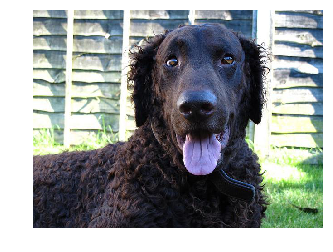

Dog detected!
 This is a picture of a .... Curly-coated retriever

-----------------------------------



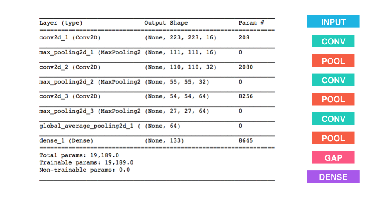

Error! Can't detect anything.....

-----------------------------------



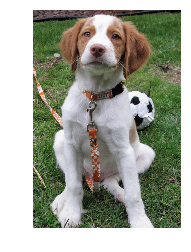

Dog detected!
 This is a picture of a .... Brittany

-----------------------------------



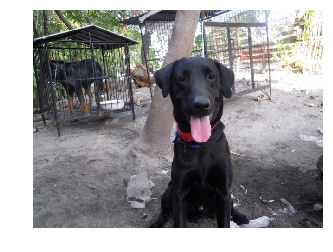

Dog detected!
 This is a picture of a .... Labrador retriever

-----------------------------------



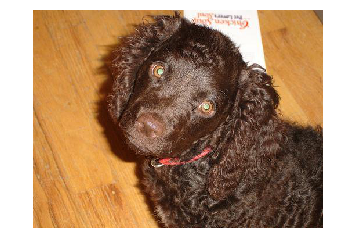

Dog detected!
 This is a picture of a .... Curly-coated retriever

-----------------------------------



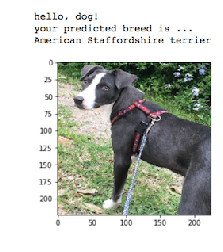

Dog detected!
 This is a picture of a .... Great dane

-----------------------------------



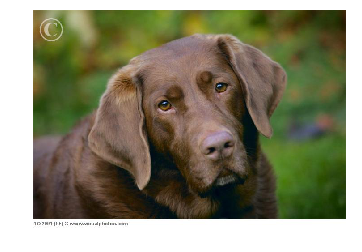

Dog detected!
 This is a picture of a .... Chesapeake bay retriever

-----------------------------------



In [27]:
import os
for image in os.listdir('./images'):
    img_path = os.path.join('./images', image)
    run_app(img_path)

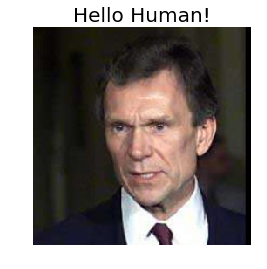

If you were a dog ... you may look like a Irish wolfhound

-----------------------------------



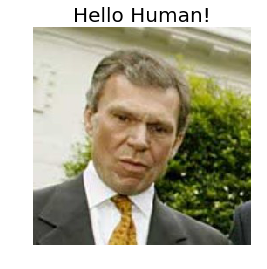

If you were a dog ... you may look like a Irish wolfhound

-----------------------------------



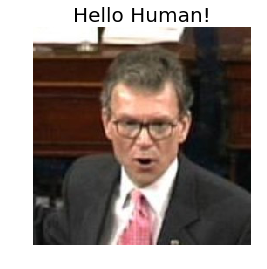

If you were a dog ... you may look like a Irish wolfhound

-----------------------------------



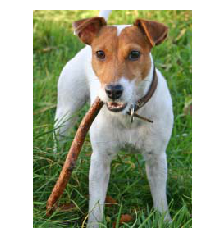

Dog detected!
 This is a picture of a .... Parson russell terrier

-----------------------------------



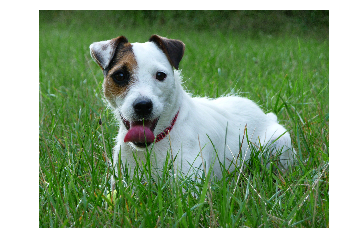

Dog detected!
 This is a picture of a .... Parson russell terrier

-----------------------------------



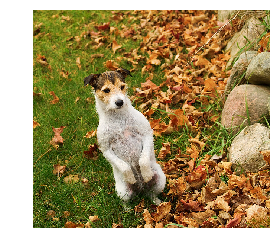

Dog detected!
 This is a picture of a .... Parson russell terrier

-----------------------------------



In [28]:
for file in np.hstack((human_files[698:701],dog_files[605:608])):
    run_app(file)

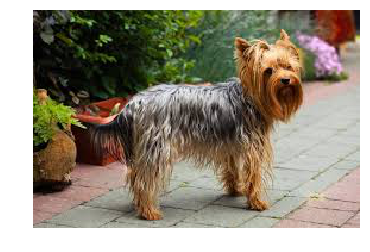

Dog detected!
 This is a picture of a .... Yorkshire terrier

-----------------------------------



In [29]:
run_app("./test_images/dog_yorkshire_project.jpg")

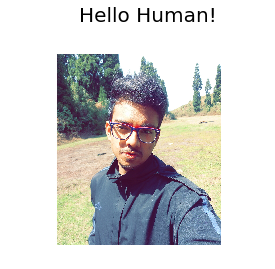

If you were a dog ... you may look like a American eskimo dog

-----------------------------------



In [30]:
run_app("./test_images/my_images.jpg")

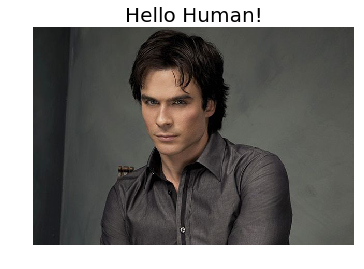

If you were a dog ... you may look like a Norwegian buhund

-----------------------------------



In [31]:
run_app("./test_images/Ian_project.jpg")

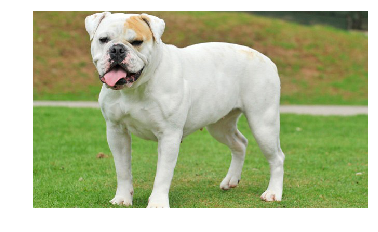

Dog detected!
 This is a picture of a .... Bulldog

-----------------------------------



In [32]:
run_app('./test_images/american_bull_dog_project.jpg')

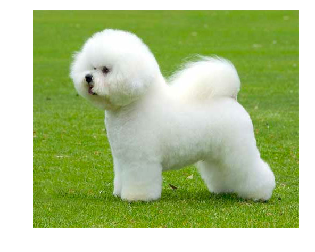

Dog detected!
 This is a picture of a .... Bichon frise

-----------------------------------



In [33]:
run_app('./test_images/Bichon Frise_project.jpg')

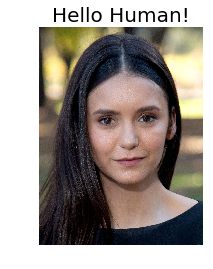

If you were a dog ... you may look like a Maltese

-----------------------------------



In [34]:
run_app('./test_images/Nina_Dobrev_project.jpg')